In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numba import njit, prange

In [4]:
##################### ASSING_ACTIVITY ###############################

@njit
def Assign_Activity(eps1, eps2, gamma):
    rand = np.random.uniform(0, 1)
    power_rand = (eps1**(1-gamma) + (eps2**(1-gamma) - eps1**(1-gamma)) * rand)**(1/(1-gamma))
    return power_rand

#################### PROBABILITY_DISTRIBUTION_OPINION ###############

@njit(parallel = True)
def Probability_Distribution_Opinion(G, numb_node, T, beta, Phi):
    # Calculates probability of node numb_node connecting to each other node.
    N = len(G)
    prob = np.zeros(N)

    # Calculate Norm
    # Norm and distances are first calculated in arrays in order to avoid race conditions
    # when parallel loops access the same variable.
    norm = np.zeros(N)
    distance = np.zeros(N)
    for i in prange (N):
        #sp = 0
        if i != numb_node: 
            # numb_node is the number of the selected node
            for u in prange (T):
                for v in prange (T):
                    distance[i] += (G[i][u] - G[numb_node][u]) * (G[i][v] - G[numb_node][v]) * Phi[u][v]
                    # Avoid error NaN
                    if distance[i] == 0:
                        distance[i] = 1e-12
            norm[i] += np.sqrt(abs(distance[i]))**(-beta)
        
    norm_sum = 0
    for i in range (N):
        norm_sum += norm[i]

    # Calculate Probability of contact
    for i in prange (N): 
        if i != numb_node:
            prob[i] = (np.sqrt(abs(distance[i]))**(-beta) / norm_sum)
    return prob
    
#################### ODEs ###########################################

@njit(parallel = True)
def ODEs(N, T, A, K, alpha, Phi, current_opinions, opinions_step):
    # Determine social influence to return the differential. current_opinions and opinions_step
    # are arrays of the form [..., [agent_i_op1, agent_i_op2], [agent_i+1_op1, agent_i+1_op2], ...]
    influence = np.zeros((N,T))
    for i in prange (N):
        for o in prange (T):
            # Go through connected agents of i
            count = 0
            while A[i][count] != N+1:
                influence[i][o] += np.tanh(alpha * np.dot(Phi, current_opinions[A[i][count]])[o])
                count += 1

    #return differential
    dxdt = -opinions_step + K * influence
    return dxdt

#################### RK4 #############################################

@njit(parallel = True)
def RK4(G, T, A, K, alpha, Phi, dt):
    N = len(G)
    # Save current opinions
    current_opinions = np.zeros((N,T))
    for i in prange (N):
        for j in prange (T):
            current_opinions[i][j] += G[i][j]

    # Calculate ks
    k1 = dt * ODEs(N, T, A, K, alpha, Phi, current_opinions, current_opinions)
    k2 = dt * ODEs(N, T, A, K, alpha, Phi, current_opinions, current_opinions + 0.5 * k1)
    k3 = dt * ODEs(N, T, A, K, alpha, Phi, current_opinions, current_opinions + 0.5 * k2)
    k4 = dt * ODEs(N, T, A, K, alpha, Phi, current_opinions, current_opinions + k3)

    # Calculate total change and update opinions
    k = 1/6 * (k1 + 2*k2 + 2*k3 + k4)
    current_opinions += k
    for i in prange (N):
        for j in prange (T):
            G[i][j] = current_opinions[i][j]

#################### SET_BACK ########################################

@njit
def Set_back(G, numb, boundary):
    # This function sets the radius in the opinion-phase-space of the node back to boundary.

    # Calculate radius
    radius = 0
    for i in range(2):
        radius += G[numb][i]**2
    radius = np.sqrt(radius)

    if radius > boundary:
        # Calculate angle in xy-plain so that only the radius is affected by the setback.
        # A small deviation from the boundary is needed because for large boundaries + Polarization
        # some nodes get the same opinion and thus their probability to interact becomes infinetly large.
        phi = np.arctan(G[numb][1]/G[numb][0])
        rand = np.random.uniform(-1e-12,1e-12)
        G[numb][0] = np.cos(phi) * (boundary + rand)
        G[numb][1] = np.sin(phi) * (boundary + rand)

#################### UPDATE_ADJACENCY_MATRIX #########################

@njit(parallel = True)
def Update_Adjacency_Matrix(Adj, A, N):
    # Updates Adjacency Matrix. If a connection is established multiple times in the
    # Network iterations, the connection is still only counted as one connection,
    # so that it isn´t weighted.
    for i in prange(N):
        j = 0
        # Again N+1 is the breaking value
        while A[i][j] != N+1:
            con = A[i][j]
            Adj[i][con] = 1
            Adj[con][i] = 1
            j += 1

##################### CONNECT #######################################

def Connect(N, m, G, G_num, T, beta, Phi):
    # Form adjacency array for timestep. Array entry i contains all adjacent nodes of i. Other values are initialized with N+1
    # as a breaking value so ODEs doesn´t go through the whole array
    A = np.full((N,N), N+1)
    # Create counting array to place adjacent nodes correctly in array
    count_arr = np.zeros(N, dtype=int)

    for i in range (N):
        # Go through nodes and possibly activate them
        rand = np.random.uniform(0,1)
        if rand <= G[i][T]:
            # Pick m other nodes randomly. No exception of i needed, since
            # P_D_O excludes i already
            prob = Probability_Distribution_Opinion(G, i, T, beta, Phi)
            picks = np.random.choice(G_num, m, replace=False, p=prob)
            #Update adjacency list: append nodes j to i´s place and vice versa
            for j in picks:
                A[i][count_arr[i]] = j
                A[j][count_arr[j]] = i
                count_arr[i] += 1
                count_arr[j] += 1

    return A

##################### SAVE ###########################################

def Save(save, Adj, N, T, filename):
    # Export save to csv
    # Create column indices (optional)
    nodes_ind = []
    for i in range (N):
        nodes_ind.append(f'Node_{i}')
    # Create row indices (optional)
    op_ind = []
    op_ind.append('activity')
    for i in range (runtime_net):
        for j in range (T):
            op_ind.append(f'iteration {i} op {j}')
    # Create Dataframe and convert it to .csv
    df = pd.DataFrame(save, columns = nodes_ind, index = op_ind)
    Ordner = "Phase"
    df.to_csv(f"D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Bound\{Ordner}\{filename}.csv", index = False, header = False)

    # Save Adjacency Matrix
    pd.DataFrame(Adj).to_csv(f"D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Bound\{Ordner}\{filename}_mat.csv", index = False, header = False)




##################### OPINION_DYNAMICS ################################

def Opinion_Dynamics_2D(N, T, m, K, alpha, beta, gamma, Phi, eps1, eps2, runtime_net, runtime_op, dt, filename, boundary, frac_act):
    # Parameters N to eps1 are the same as in the paper introducing the model. Eps2 is the upper bound for activity,
    # runtime_net is the number of times a new AD-network is formed, runtime_op is the number of opinion-iterations
    # performed on that network. Default is runtime_op = 1. dt is the integration time-step and filename is a string
    # containing the name of the file in which the opinion dynamcis of the agents are saved (filename.csv).

    # Create array to save opinions of all agents after every network-iteration
    save = np.zeros((runtime_net * T + 1, N))

    G = np.zeros((N,T+2))
    # Give each array entry (node) a number, save in array G_num
    G_num = np.arange(0,N)

    # Initialize Activity and Opinions of Nodes
    for i in range (N):
        G[i][T] = Assign_Activity(eps1, eps2, gamma)
        G[i][T+1] = i
        for j in range (T):
            G[i][j] = np.random.normal(0, np.sqrt(2.5))
    # Save activities of agents in first row of save

    for i in range (N):
        save[0][i] += G[i][T]

    # To later retrieve the integrated network over the last 70 iterations (As in the paper) create
    # an adjacency matrix
    Adj = np.zeros((N,N))

    # Sorting and finding top active nodes
    act = np.floor(float(N)*frac_act)
    G_sorted = G[np.argsort(G[:,T])]

    # Perform Iterations until runtime_net is reached
    iteration_net = 0
    while iteration_net < runtime_net:

        # Setting boundary for top fraction frac of nodes
        it = 0
        while it < act:
            # Nodes with radius > boundary get back to that radius with direction in phase-space determined by their angle.
            # This implementation is only for 2D!
            numb = int(G_sorted[N-1 - it][T+1])

            # Perform setback of opinion
            Set_back(G, numb, boundary)

            it += 1
        
        # Form connections between Agents
        A = Connect(N, m, G, G_num, T, beta, Phi)
        
        # Calculate the influence of the nodes on eachother
        iteration_op = 0
        while iteration_op < runtime_op:
            # Update opinions via Runge-Kutta 4
            RK4(G, T, A, K, alpha, Phi, dt)
            # increase iteration
            iteration_op += 1
        
        # Save opinions of agents
        for i in range (N):
            for j in range(T):
                # first row of save contains activities. After that for each iteration there´s a row for each iteration,
                # i.e. for two opinions two rows per iteration. 
                save[(T*iteration_net)+j+1][i] += G[i][j]

        # Update adjacency matrix if last 70 iterations are reached
        if iteration_net >= runtime_net - 71:
            Update_Adjacency_Matrix(Adj, A, N)

        # Print progress bar
        if iteration_net % (int(runtime_net/100)) == 0:
            percent = int(100 * iteration_net/runtime_net)
            #print(percent)
            left = 40 * percent // 100
            right = 40 - left
    
            tags = "#" * left
            spaces = " " * right
            percents = f"{percent:.0f}%"
    
            print("\r[", tags, spaces, "]", percents, sep="", end="", flush=True)

        iteration_net += 1
    
    # Print last part of progress bar
    percents = f"{100:.0f}%"
    tags = "#" * 40
    print("\r[", tags, "]", percents, "\n", sep="", end="", flush=True)

    Save(save, Adj, N, T, filename)

    return 0
        
            



In [5]:
N = 2500 # 1000 nodes should be the minimum, below initial fluctuations take over and polarization becomes instable
T = 2
m = 25 # np.floor(N+50/100)
K = 3
alpha = np.arange(1.8, 4.1, 0.1)
beta = 5.0
gamma = 2.1
Phi = np.array([[1.0, 0.1], [0.1, 1.0]])
cosd = np.arange(0.0, 1.1, 0.1)
eps1 = 0.01
eps2 = 1.0
runtime_net = 1000 # Stability is reached from about 500 iterations
runtime_op = 1
step = 0.01
boundary = 1e-10
frac = np.arange(0.0,1.0,0.1)
print("m: ", m)
# File Names should be a 2-dim array with the first dimension being for each wanted value of a parameter
# and the second dimension full of array names for the multiple simulations.
File_Names = []
for i in range (len(alpha)):
    File_Names2 = []
    for j in range (len(cosd)):
        for k in range (1):
            File_Names2.append(f'a{alpha[i]:.1f}_b{beta}_cosd{cosd[j]:.1f}_frac_{frac[1]}_{k+1}')
    File_Names.append( File_Names2 )


#print(File_Names)
#File_Names = [["Test"]]

print(frac[1])
print(boundary)

m:  25
0.1
1e-10


In [6]:
fracs = np.array([0.2])
for k in range (len(fracs)):
    frac = fracs[k]
    File_Names = []
    for i in range (len(alpha)):
        File_Names2 = []
        for j in range (len(cosd)):
            for l in range (1):
                File_Names2.append(f'a{alpha[i]:.1f}_b{beta}_cosd{cosd[j]:.1f}_frac_{frac}_{l+2}')
        File_Names.append( File_Names2 )
    print(File_Names)

    for i in range (len(alpha)):
        for j in range (len(cosd)):
            print(f"\rsimulation {i*len(File_Names[0]) + j + 1 + k*len(File_Names) * len(File_Names[0])} of {len(File_Names) * len(File_Names[0])}")
            Phi = np.array([[1.0,cosd[j]],[cosd[j],1.0]])
            #print(f"Phi: {Phi}")
            Opinion_Dynamics_2D(N, T, m, K, alpha[i], beta, gamma, Phi, eps1, eps2, runtime_net, runtime_op, step, File_Names[i][j], boundary, frac)

[['a1.8_b5.0_cosd0.0_frac_0.2_2', 'a1.8_b5.0_cosd0.1_frac_0.2_2', 'a1.8_b5.0_cosd0.2_frac_0.2_2', 'a1.8_b5.0_cosd0.3_frac_0.2_2', 'a1.8_b5.0_cosd0.4_frac_0.2_2', 'a1.8_b5.0_cosd0.5_frac_0.2_2', 'a1.8_b5.0_cosd0.6_frac_0.2_2', 'a1.8_b5.0_cosd0.7_frac_0.2_2', 'a1.8_b5.0_cosd0.8_frac_0.2_2', 'a1.8_b5.0_cosd0.9_frac_0.2_2', 'a1.8_b5.0_cosd1.0_frac_0.2_2'], ['a1.9_b5.0_cosd0.0_frac_0.2_2', 'a1.9_b5.0_cosd0.1_frac_0.2_2', 'a1.9_b5.0_cosd0.2_frac_0.2_2', 'a1.9_b5.0_cosd0.3_frac_0.2_2', 'a1.9_b5.0_cosd0.4_frac_0.2_2', 'a1.9_b5.0_cosd0.5_frac_0.2_2', 'a1.9_b5.0_cosd0.6_frac_0.2_2', 'a1.9_b5.0_cosd0.7_frac_0.2_2', 'a1.9_b5.0_cosd0.8_frac_0.2_2', 'a1.9_b5.0_cosd0.9_frac_0.2_2', 'a1.9_b5.0_cosd1.0_frac_0.2_2'], ['a2.0_b5.0_cosd0.0_frac_0.2_2', 'a2.0_b5.0_cosd0.1_frac_0.2_2', 'a2.0_b5.0_cosd0.2_frac_0.2_2', 'a2.0_b5.0_cosd0.3_frac_0.2_2', 'a2.0_b5.0_cosd0.4_frac_0.2_2', 'a2.0_b5.0_cosd0.5_frac_0.2_2', 'a2.0_b5.0_cosd0.6_frac_0.2_2', 'a2.0_b5.0_cosd0.7_frac_0.2_2', 'a2.0_b5.0_cosd0.8_frac_0.2_2', 'a

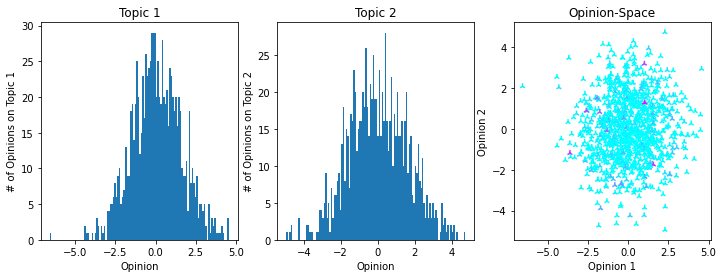

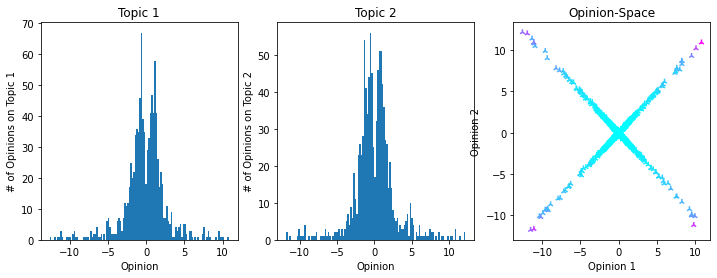

In [ ]:
filename = File_Names[0][0]
data = np.loadtxt(f'D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Bound\Phase\{filename}.csv', delimiter=',')

def Plot_Opinion_Distribution_2d(data1, data2, data_act):
    op1_list = data1
    op2_list = data2

    fig, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].set_title("Topic 1")
    ax[0].set_xlabel("Opinion")
    ax[0].set_ylabel("# of Opinions on Topic 1")
    ax[0].hist(op1_list, bins=120)
    ax[1].set_title("Topic 2")
    ax[1].set_xlabel("Opinion")
    ax[1].set_ylabel("# of Opinions on Topic 2")
    ax[1].hist(op2_list, bins=120)
    ax[2].set_title("Opinion-Space")
    ax[2].set_xlabel("Opinion 1")
    ax[2].set_ylabel("Opinion 2")
    ax[2].scatter(op1_list, op2_list, c=data_act, cmap='cool', marker = '2')
    plt.show()

Plot_Opinion_Distribution_2d(data[1], data[2], data[0])
Plot_Opinion_Distribution_2d(data[len(data)-2], data[len(data)-1], data[0])